# Credit Card Fraud Detection

In [71]:
import warnings
warnings.filterwarnings('ignore')

In [72]:
import pandas as pd
from dataloader import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [73]:
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score


def plot_roc_curve(
    y_true: np.ndarray,
    y_scores: np.ndarray,
    model_name: str = "Model",
    ax: plt.Axes = None,
    color: str = None,
) -> Tuple[float, plt.Axes]:
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auroc = roc_auc_score(y_true, y_scores)

    # Create figure if no axes provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot ROC curve
    ax.plot(
        fpr, tpr, color=color, linewidth=2, label=f"{model_name} (AUROC = {auroc:.3f})"
    )

    # Plot diagonal line (random classifier)
    ax.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Random Classifier (AUROC = 0.500)")

    # Formatting
    ax.set_xlabel("False Positive Rate", fontsize=12)
    ax.set_ylabel("True Positive Rate", fontsize=12)
    ax.set_title("ROC Curve", fontsize=14, fontweight="bold")
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    return auroc, ax


## 1. Data Loading and Preprocessing with DataLoader


In [74]:
dataloader = DataLoader('creditcard.csv', random_state=1)

processed_data = dataloader.load_and_preprocess()
print(f"Processed data shape: {processed_data.shape}")
print(f"Class distribution:")
print(processed_data['Class'].value_counts())

Processed data shape: (284807, 31)
Class distribution:
Class
0.0    284315
1.0       492
Name: count, dtype: int64


## 2. Data Splitting - Imbalanced Dataset


In [75]:
# Split data using the same sizes as original notebook
train_df, test_df, val_df = dataloader.split_data(train_size=240000, test_size=22000)

print("Dataset sizes:")
print(f"Train: {len(train_df)}, Test: {len(test_df)}, Validation: {len(val_df)}")

print("\nClass distribution:")
print(f"Train: {train_df['Class'].value_counts().to_dict()}")
print(f"Test: {test_df['Class'].value_counts().to_dict()}")
print(f"Validation: {val_df['Class'].value_counts().to_dict()}")


Dataset sizes:
Train: 240000, Test: 22000, Validation: 22807

Class distribution:
Train: {0.0: 239589, 1.0: 411}
Test: {0.0: 21955, 1.0: 45}
Validation: {0.0: 22771, 1.0: 36}


In [76]:
# Convert to numpy arrays for model training
(X_train, y_train), (X_test, y_test), (X_val, y_val) = dataloader.get_numpy_splits(train_df, test_df, val_df)

print("Array shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")


Array shapes:
X_train: (240000, 30), y_train: (240000,)
X_test: (22000, 30), y_test: (22000,)
X_val: (22807, 30), y_val: (22807,)


## 3. Model Training and Evaluation - Imbalanced Dataset

### 3.1 Logistic Regression


In [77]:
# Logistic Regression with GridSearch
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1.0, 10.0],
    'class_weight': [None, 'balanced'],
}

logistic_model = LogisticRegression(max_iter=1000, random_state=1)
grid_search = GridSearchCV(logistic_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

logistic_model = grid_search.best_estimator_

print("Logistic Regression - Imbalanced Dataset")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Training accuracy: {logistic_model.score(X_train, y_train):.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, logistic_model.predict(X_val), target_names=['Not Fraud', 'Fraud']))


Logistic Regression - Imbalanced Dataset
Best parameters: {'C': 1.0, 'class_weight': None}
Training accuracy: 0.9992

Validation Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22771
       Fraud       0.83      0.56      0.67        36

    accuracy                           1.00     22807
   macro avg       0.92      0.78      0.83     22807
weighted avg       1.00      1.00      1.00     22807



(np.float64(0.9902275799140232),
 <Axes: title={'center': 'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

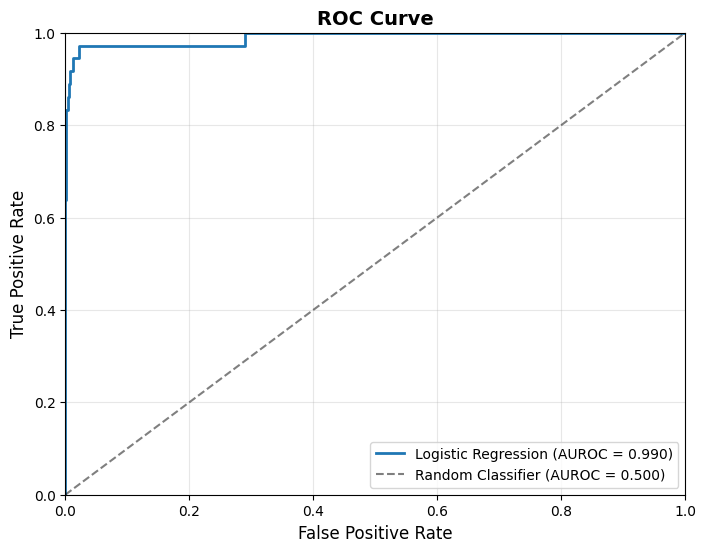

In [78]:
plot_roc_curve(y_val, logistic_model.predict_proba(X_val)[:, 1], model_name="Logistic Regression")

### 3.2 Random Forest


In [65]:
from sklearn.model_selection import RandomizedSearchCV

# Random Forest with RandomizedSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestClassifier(n_jobs=-1, random_state=1)
random_search_rf = RandomizedSearchCV(rf_model, param_grid_rf, cv=2, scoring='f1', n_jobs=-1, n_iter=5, random_state=1)
random_search_rf.fit(X_train, y_train)

rf_model = random_search_rf.best_estimator_

print("Random Forest - Imbalanced Dataset")
print(f"Best parameters: {random_search_rf.best_params_}")
print(f"Training accuracy: {rf_model.score(X_train, y_train):.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, rf_model.predict(X_val), target_names=['Not Fraud', 'Fraud']))


Random Forest - Imbalanced Dataset
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'class_weight': 'balanced'}
Training accuracy: 1.0000

Validation Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22771
       Fraud       0.88      0.78      0.82        36

    accuracy                           1.00     22807
   macro avg       0.94      0.89      0.91     22807
weighted avg       1.00      1.00      1.00     22807



(np.float64(0.9707053074329435),
 <Axes: title={'center': 'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

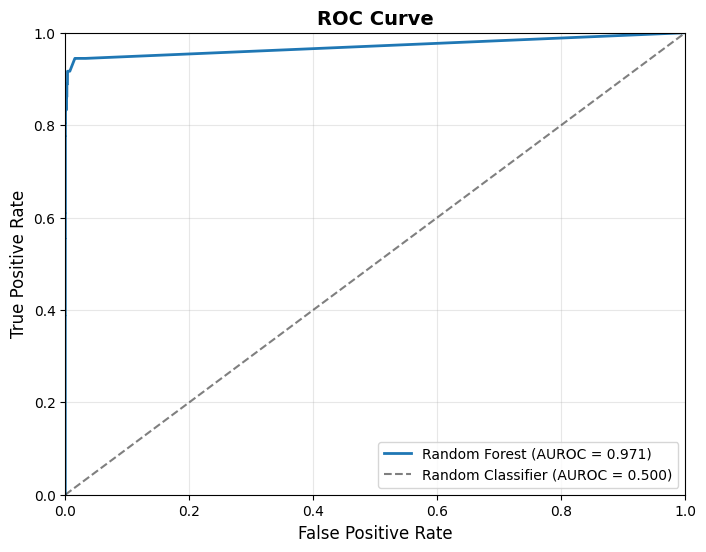

In [66]:
plot_roc_curve(y_val, rf_model.predict_proba(X_val)[:, 1], model_name="Random Forest")

### 3.3 Gradient Boosting


In [16]:
# Gradient Boosting
gbc_model = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1, random_state=0)
gbc_model.fit(X_train, y_train)

print("Gradient Boosting - Imbalanced Dataset")
print("\nValidation Classification Report:")
print(classification_report(y_val, gbc_model.predict(X_val), target_names=['Not Fraud', 'Fraud']))

Gradient Boosting - Imbalanced Dataset

Validation Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22771
       Fraud       0.67      0.67      0.67        36

    accuracy                           1.00     22807
   macro avg       0.83      0.83      0.83     22807
weighted avg       1.00      1.00      1.00     22807



(np.float64(0.833069840293941),
 <Axes: title={'center': 'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

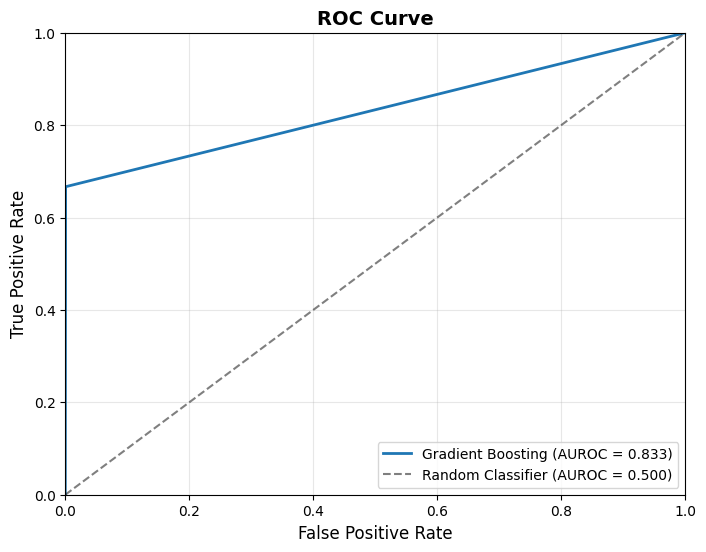

In [60]:
plot_roc_curve(y_val, gbc_model.predict_proba(X_val)[:, 1], model_name="Gradient Boosting")

In [79]:
# Linear SVC with Grid Search
param_grid_svc = {
    'C': [0.1, 1, 10],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000, 2000, 3000]
}

svc_model = LinearSVC(random_state=1)
grid_search_svc = GridSearchCV(svc_model, param_grid_svc, cv=2, scoring='f1', n_jobs=-1)
grid_search_svc.fit(X_train, y_train)

svc_model = grid_search_svc.best_estimator_

print("Linear SVC - Imbalanced Dataset")
print(f"Best parameters: {grid_search_svc.best_params_}")
print(f"Training accuracy: {svc_model.score(X_train, y_train):.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, svc_model.predict(X_val), target_names=['Not Fraud', 'Fraud']))

Linear SVC - Imbalanced Dataset
Best parameters: {'C': 0.1, 'class_weight': None, 'max_iter': 1000}
Training accuracy: 0.9992

Validation Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22771
       Fraud       0.81      0.47      0.60        36

    accuracy                           1.00     22807
   macro avg       0.90      0.74      0.80     22807
weighted avg       1.00      1.00      1.00     22807



## 4. Balanced Dataset Creation and Model Training


In [80]:
# Create balanced dataset
balanced_data = dataloader.create_balanced_dataset()

print(f"Balanced dataset shape: {balanced_data.shape}")
print(f"Class distribution: {balanced_data['Class'].value_counts().to_dict()}")


Balanced dataset shape: (984, 31)
Class distribution: {0.0: 492, 1.0: 492}


In [81]:
# Split balanced data
(X_train_b, y_train_b), (X_test_b, y_test_b), (X_val_b, y_val_b) = dataloader.split_balanced_data(
    balanced_data, train_ratio=0.71, test_ratio=0.145, val_ratio=0.145
)

print("Balanced dataset array shapes:")
print(f"X_train_b: {X_train_b.shape}, y_train_b: {y_train_b.shape}")
print(f"X_test_b: {X_test_b.shape}, y_test_b: {y_test_b.shape}")
print(f"X_val_b: {X_val_b.shape}, y_val_b: {y_val_b.shape}")

print("\nClass distributions:")
print(f"Train: {pd.Series(y_train_b).value_counts().to_dict()}")
print(f"Test: {pd.Series(y_test_b).value_counts().to_dict()}")
print(f"Validation: {pd.Series(y_val_b).value_counts().to_dict()}")


Balanced dataset array shapes:
X_train_b: (698, 30), y_train_b: (698,)
X_test_b: (142, 30), y_test_b: (142,)
X_val_b: (144, 30), y_val_b: (144,)

Class distributions:
Train: {1: 351, 0: 347}
Test: {0: 73, 1: 69}
Validation: {1: 72, 0: 72}


## 5. Model Training and Evaluation - Balanced Dataset


In [82]:
# Logistic Regression
logistic_model_b = LogisticRegression(random_state=1)
grid_search = GridSearchCV(logistic_model_b, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_b, y_train_b)
logistic_model_b = grid_search.best_estimator_

# Random Forest
rf_model_b = RandomForestClassifier(max_depth=2, n_jobs=-1, random_state=1)
random_search_rf = RandomizedSearchCV(rf_model_b, param_grid_rf, cv=2, scoring='f1', n_jobs=-1, n_iter=5, random_state=1)
random_search_rf.fit(X_train_b, y_train_b)
rf_model_b = random_search_rf.best_estimator_

# Gradient Boosting
gbc_model_b = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=2, random_state=0)
gbc_model_b.fit(X_train_b, y_train_b)

# Linear SVC
svc_model_b = LinearSVC(class_weight='balanced', max_iter=2000, random_state=1)
grid_search_svc = GridSearchCV(svc_model_b, param_grid_svc, cv=2, scoring='f1', n_jobs=-1)
grid_search_svc.fit(X_train_b, y_train_b)
svc_model_b = grid_search_svc.best_estimator_


In [83]:
models_b = {
    'Logistic Regression': logistic_model_b,
    'Random Forest': rf_model_b,
    'Gradient Boosting': gbc_model_b,
    # 'Linear SVC': svc_model_b
}

for name, model in models_b.items():
    print(f"\n{name}:")
    print(classification_report(y_val_b, model.predict(X_val_b), target_names=['Not Fraud', 'Fraud']))


Logistic Regression:
              precision    recall  f1-score   support

   Not Fraud       0.96      0.93      0.94        72
       Fraud       0.93      0.96      0.95        72

    accuracy                           0.94       144
   macro avg       0.94      0.94      0.94       144
weighted avg       0.94      0.94      0.94       144


Random Forest:
              precision    recall  f1-score   support

   Not Fraud       0.93      0.97      0.95        72
       Fraud       0.97      0.93      0.95        72

    accuracy                           0.95       144
   macro avg       0.95      0.95      0.95       144
weighted avg       0.95      0.95      0.95       144


Gradient Boosting:
              precision    recall  f1-score   support

   Not Fraud       0.94      0.93      0.94        72
       Fraud       0.93      0.94      0.94        72

    accuracy                           0.94       144
   macro avg       0.94      0.94      0.94       144
weighted avg    

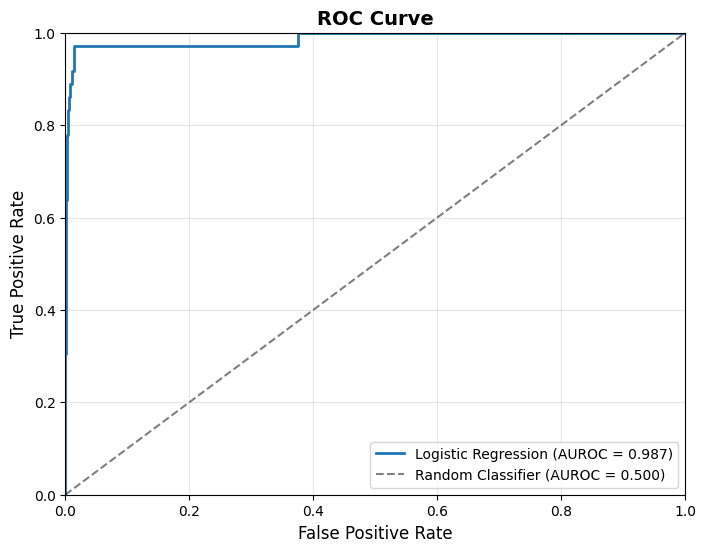

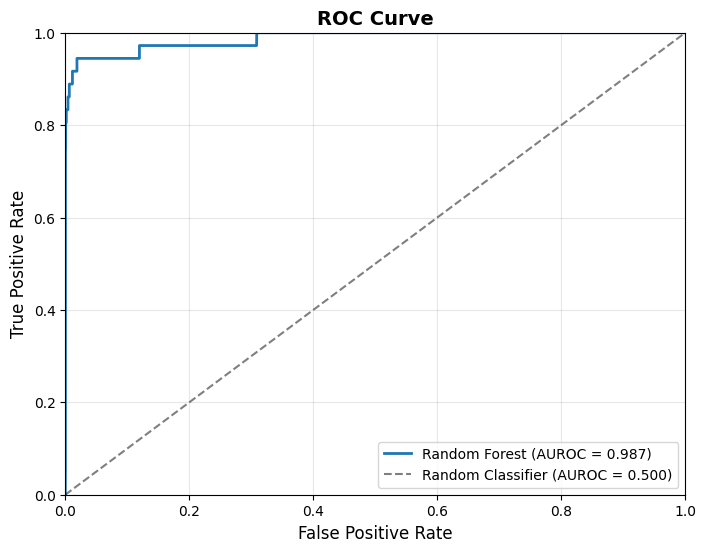

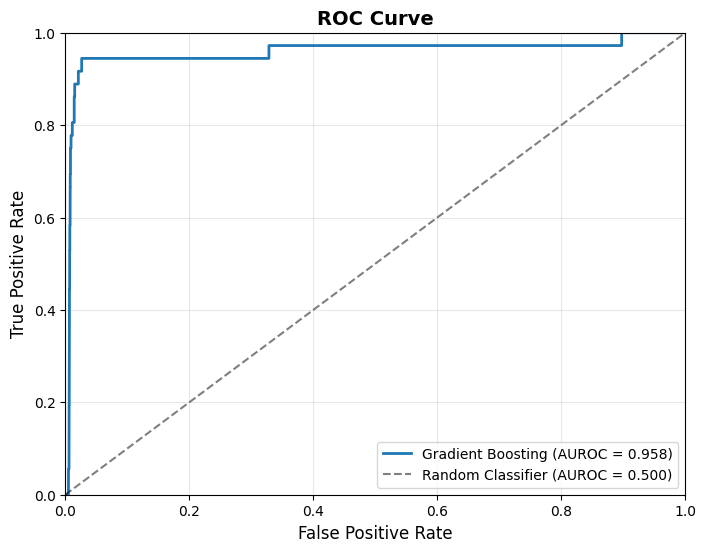

In [84]:
for model_name, model in models_b.items():
    plot_roc_curve(y_val, model.predict_proba(X_val)[:, 1], model_name=model_name)

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

neural_network = Sequential()
neural_network.add(InputLayer((X_train.shape[1],)))
neural_network.add(Dense(2, 'relu'))
neural_network.add(BatchNormalization())
neural_network.add(Dense(1, 'sigmoid'))

checkpoint = ModelCheckpoint('neural_net.keras', save_best_only=True)
neural_network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
neural_network.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, callbacks=checkpoint)

Epoch 1/40
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 3s 366us/step - accuracy: 0.9613 - loss: 0.1577 - val_accuracy: 0.9992 - val_loss: 0.0088
Epoch 2/40
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 3s 340us/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9990 - val_loss: 0.0091
Epoch 3/40
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 3s 357us/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9993 - val_loss: 0.0070
Epoch 4/40
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 3s 346us/step - accuracy: 0.9995 - loss: 0.0029 - val_accuracy: 0.9988 - val_loss: 0.0099
Epoch 5/40
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 3s 337us/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9987 - val_loss: 0.0113
Epoch 6/40
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 3s 344us/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9989 - val_loss: 0.0104
Epoch 7/40
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 3s 349us/step - accuracy: 0.9994 - loss: 0.0033 - val_accuracy: 0.9993 - val_loss: 0.0073
Epoch 8/40
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 3s 333us/step - accuracy: 0.9994 -

In [87]:
def neural_net_predictions(model, x):
  return (model.predict(x).flatten() > 0.5).astype(int)
neural_net_predictions(neural_network, X_val)

713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


array([0, 0, 0, ..., 0, 0, 0])

In [88]:
print(classification_report(y_val_b, neural_net_predictions(neural_network, X_val_b), target_names=['Not Fraud', 'Fraud']))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

   Not Fraud       0.90      1.00      0.95        72
       Fraud       1.00      0.89      0.94        72

    accuracy                           0.94       144
   macro avg       0.95      0.94      0.94       144
weighted avg       0.95      0.94      0.94       144



  1/713 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step

713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


(np.float64(0.9906496567271237),
 <Axes: title={'center': 'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

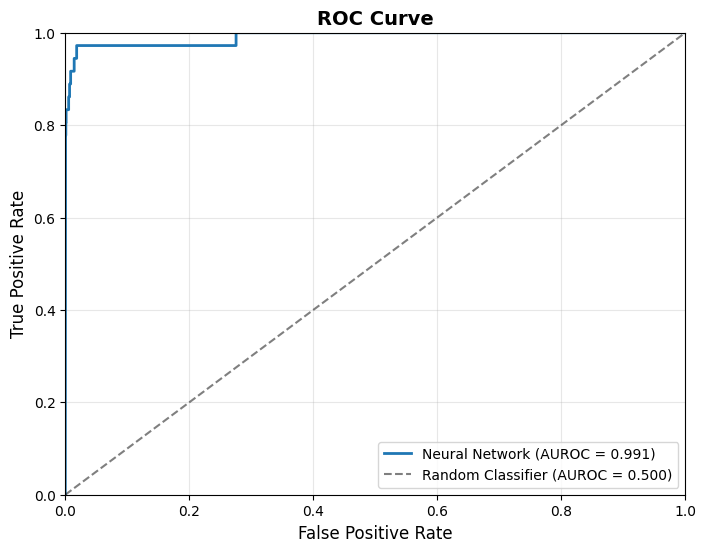

In [89]:
plot_roc_curve(y_val, neural_network.predict(X_val).flatten(), model_name="Neural Network")